# Regresión no lineal - Diego Jafet Garza Segovia

Primero, se importara la base de datos Tiempo de Entrega y se guardara en df. Para eso se necesitara importar la libreria de pandas (pd).

Luego se analizara un poco la base de datos, por lo que se imprimira las dimensiones del data frame, los tipos de datos que tiene, y las primeras 5 filas de datos.

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Tiempo de Entrega.csv")
print("Dimensiones del data frame: ", df.shape)
print("\nVariable  -  Tipo de dato\n", df.dtypes)
print("\n", df.head(5))

Dimensiones del data frame:  (443, 2)

Variable  -  Tipo de dato
 Tiempo          float64
Calificacion     object
dtype: object

       Tiempo Calificacion
0  85.076389           85
1  84.675556           85
2  79.553889          110
3  75.310556          110
4  64.958611          110


Como se puede ver, no todos los datos son de un tipo manejable (numerico), por lo que se convertira la columna "Calificacion" en una columna de tipo numerica, y adicionalmente eliminaran todos los datos que se pueden considerar basura ("NA", "%<>", etc) para evitar cualquier tipo de error en la conversion.

Posteriormente se generara y mostrara una grafica de los datos.

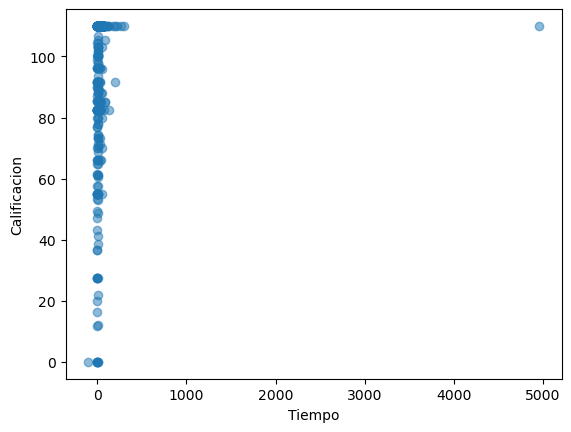

In [187]:
df["Tiempo"] = pd.to_numeric(df["Tiempo"], errors = "coerce")
df["Calificacion"] = pd.to_numeric(df["Calificacion"], errors = "coerce")
df = df.dropna()

plt.scatter(df["Tiempo"], df["Calificacion"], alpha = 0.5)
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.show()

Segun la grafica, se puede ver que claramente hay valores atipicos, como el dato que tiene como Tiempo casi 5000, o los que son menos a 0 (es decir, entregados fuera de tiempo). Para limpiar la base de datos de forma objetiva y no subjetiva, se mantendran unicamente los datos dentro del rango interquartil.

Se imprimira posteriormente las dimensiones de este, para corroborar que aun haya una cantidad de datos manejables, y la grafica de los datos ya filtrados.

Dimensiones del data frame:  (373, 2) 



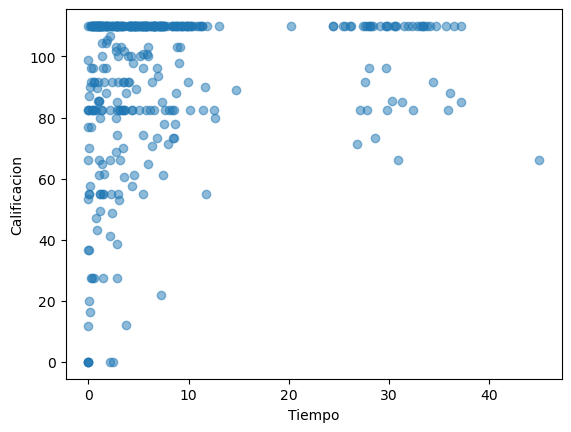

In [188]:
k = 3
Q1 = df["Tiempo"].quantile(0.25)
Q3 = df["Tiempo"].quantile(0.75)
df = df[(df["Tiempo"] >= Q1 - k*(Q3 - Q1)) & (df["Tiempo"] <= Q3 + k*(Q3-Q1))]

Q1 = df["Calificacion"].quantile(0.25)
Q3 = df["Calificacion"].quantile(0.75)
df = df[(df["Calificacion"] >= Q1 - k*(Q3 - Q1)) & (df["Calificacion"] <= Q1 + k*(Q3 - Q1))]

print("Dimensiones del data frame: ", df.shape, "\n")

plt.scatter(df["Tiempo"], df["Calificacion"], alpha = 0.5)
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.show()

Ahora, se separaran los datos en datos de manera aleatoria en entrenamiento y prueba, con una relacion de 70/30. Se imprimira en la consola el promedio de estas nuevas variables.

In [205]:
entre = df.sample(frac=0.7) #entrenamiento
prueba = df.drop(entre.index)

xEntre = entre["Tiempo"]
yEntre = entre["Calificacion"]

xPrueba = prueba["Tiempo"]
yPrueba = prueba["Calificacion"]

print("Promedio Tiempo (Entrenamiento): ", xEntre.mean())
print("Promedio Tiempo (Prueba): ", xPrueba.mean())
print("\nPromedio Calificacion (Entrenamiento): ", yEntre.mean())
print("Promedio Calificacion (Prueba): ", yPrueba.mean())

Promedio Tiempo (Entrenamiento):  7.90383993191954
Promedio Tiempo (Prueba):  7.729290674589286

Promedio Calificacion (Entrenamiento):  93.69011494252874
Promedio Calificacion (Prueba):  93.4768457142857


Los promedios de tiempo tienen una similitud aproximada del 97.8%, mientras que los promedios de calificacion tienen una similitud aproximada del 99.8%.

Estos datos significan que, aunque no se tienen los mismos promedios ni valores a evaluar en los datos de entrenamiento y prueba, un modelo obtenido de los datos de prueba deberia de satisfacer a los de prueba, y ser capaz de realizar predicciones acertadas.

Sabiendo esto, se entrenara un modelo de regresión polinomial (de grado 2) usando los datos de entrenamiento, y se imprimira un resumen de los resultados obtenidos.
Para esto se debera importar la clase PolynomialFeatures de sklearn.preprocessing, la biblioteca statsmodels.api (sm), y numpy (np).

In [206]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import numpy as np

xEntre = entre[["Tiempo"]].values.reshape(-1,1)
xPrueba = prueba["Tiempo"].values.reshape(-1,1)

polynomial = PolynomialFeatures(degree = 2, include_bias = False)
xEntrePoly = polynomial.fit_transform(xEntre)

model = sm.OLS(yEntre, sm.add_constant(xEntrePoly)).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Calificacion   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     13.90
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           1.85e-06
Time:                        07:45:53   Log-Likelihood:                -1201.2
No. Observations:                 261   AIC:                             2408.
Df Residuals:                     258   BIC:                             2419.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.6842      2.574     32.117      0.0

Segun estos resultados, se puede notar como el coeficiente es positivo, significando que entre mas grande sea el tiempo mejor sera la calificacion, o bien, a menor tiempo menor calificacion. Adicionalmente se puede decir con mas del 95% de confianza que el tiempo no es insignificante, ya que el p-value es menor a 0.05.

Ahora, se entrenara un modelo de regresión segmentada, para la cual se debera importar la clase PiecewiseRegressor de mlinsights.mlmodel. Adicionalmente, se usara en "bins" para que automaticamente se creén los segmentos.

Posteriormente se imprimira en la consola la gráfica correspondiente.

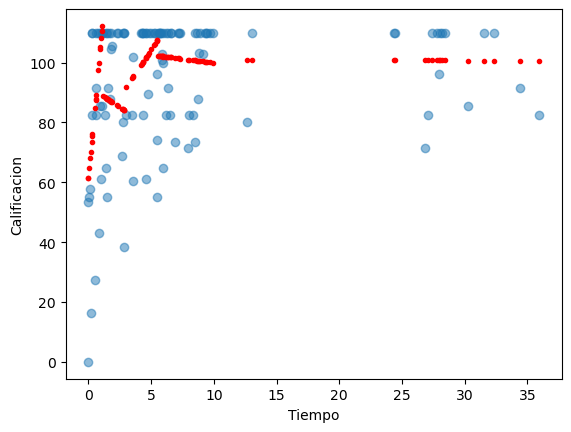

In [211]:
from mlinsights.mlmodel import PiecewiseRegressor

ms = PiecewiseRegressor("bins").fit(xEntre, yEntre)
yGorritoSEG = ms.predict(xPrueba)

plt.scatter(xPrueba, yPrueba, alpha = 0.5)
plt.plot(xPrueba, yGorritoSEG, "r.")
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.show()

Ahora, se entrenara un modelo KNN (K-Nearest Neighbors) (con valor k igual a 10 para evitar un sub o sobre ajuste), para el cual se debera importar la clase KNeighborsRegressor de sklearn.neighbors.

Nuevamente, se creara y se imprimira la gráfica correspondiente.

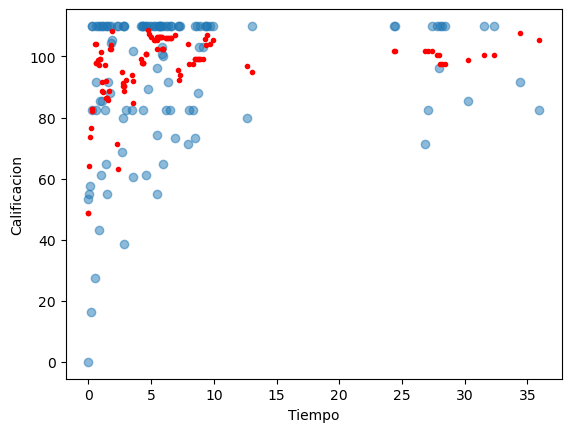

In [212]:
from sklearn.neighbors import KNeighborsRegressor

k = 10
modeloKNN = KNeighborsRegressor(n_neighbors=k).fit(xEntre, yEntre)
yGorritoKNN = modeloKNN.predict(xPrueba)

plt.scatter(xPrueba, yPrueba, label = "Datos reales", alpha = 0.5)
plt.plot(xPrueba, yGorritoKNN, "r.")
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.show()

Se calculara el RSE en los datos de prueba para cada uno de los modelos generados, y se imprimiran en la consola.

In [215]:
yGorritoPoly = model.predict(sm.add_constant(xPruebaPoly))
RSSpoly = np.sum((yPrueba - yGorritoPoly) ** 2)
RSEpoly = np.sqrt(RSSpoly / (len(yPrueba) - 1))

RSSseg = np.sum((yPrueba - yGorritoSEG) ** 2)
RSEseg = np.sqrt(RSSseg / (len(yPrueba) - 1))

RSSknn = np.sum((yPrueba - yGorritoKNN) ** 2)
RSEknn = np.sqrt(RSSknn / (len(yPrueba) - 1))

print("RSE Regresion Polinomial: ", RSEpoly)
print("RSE Regresion Segmentada: ", RSEseg)
print("RSE Regresion KNN: ", RSEknn)

RSE Regresion Polinomial:  23.804972787844097
RSE Regresion Segmentada:  20.971099982700963
RSE Regresion KNN:  21.40791346049977


Segun los resultados anteriores, se puede notar que el modelo con el valor RSE menor es el de la Regresion Segmentada con un 20.97, significando que se podria considerar como el modelo "ganador" ya que es el que mejor se ajusta a los datos reales.

Sin embargo, debido a la naturaleza de este tipo de modelo segmentado, no solo es posible que este hasta cierto punto sobreajustado (al igual que KNN), sino que tambien se pierde la continuidad de la regresion.

Por ultimo, se generara una grafica de los tres modelos y los datos reales. Para mejor visibilidad, se diferenciaran los colores de los modelos / datos, se reajustara el tamaño de la grafica (12, 6), y se agregara un grid.

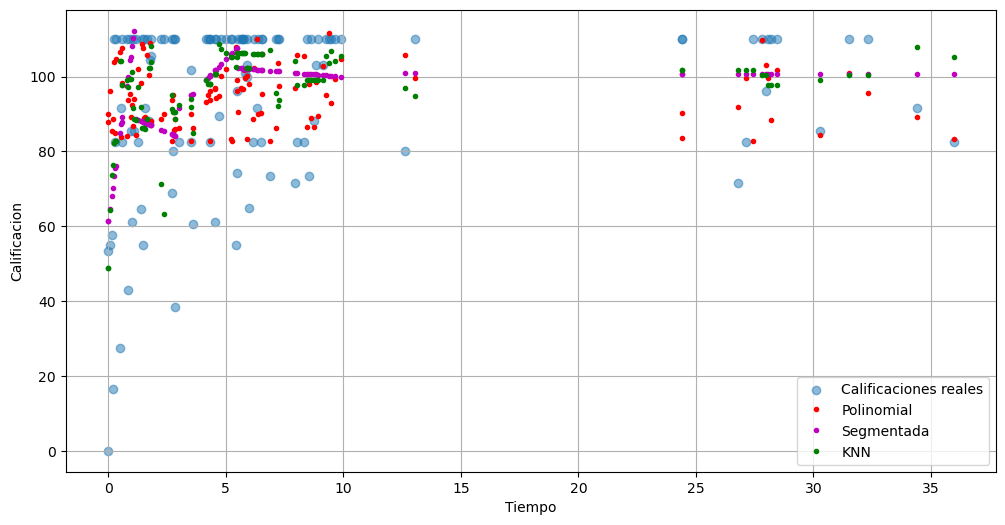

In [217]:
plt.figure(figsize = (12, 6))
plt.scatter(xPrueba, yPrueba, label="Calificaciones reales", alpha = 0.5)
plt.plot(xPrueba, yGorritoPoly, "r.", label="Polinomial")
plt.plot(xPrueba, yGorritoSEG, "m.", label="Segmentada")
plt.plot(xPrueba, yGorritoKNN, "g.", label=f"KNN")
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.legend()
plt.grid(True)
plt.show()

Segun la grafica anterior se puede notar que los tres modelos se adaptan relativamente bien a los datos reales, tal como fue predicho por los valores del RSE los cuales eran muy similares entre sí. 

Sin embargo, el menor de estos tres valores RSE, el polinomial, muestra mucha varianza en ciertas secciones pero a la vez no cubre calificaciones bajas ni intermedias, por lo que probalemente haría predicciones de calificaciones altas casi siempre.

Mientras tanto, los otros dos modelos se muestran con la capacidad de hacer predicciones de calificaciones altas como intermedias, pero no bajas. Esto representa un mejor ajuste que el modelo polinomial, sin embargo ya que los tres modelos batallan en hacer predicciones de calificaciones bajas (menor a 60), se puede asumir que hubo un deficit en la cantidad de datos de prueba de calificaciones bajas.

Esto podria representar un problema ya que, a pesar de que los datos reales refuerzan fuertemente la idea que entre mayor tiempo mayor calificacion, los modelos obtenidos tienden a tener una calificacion mas estandar independientemente del tiempo con el que se entrego (no por decir que rechazan la idea que un menor tiempo da una menor calificacion, simplemente la refuerzan menos).